In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

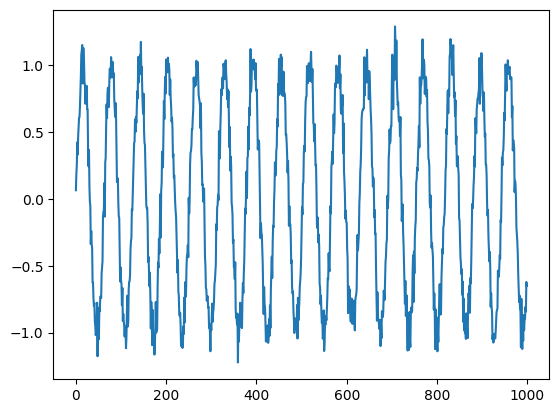

In [2]:
# make the original data
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

# plot it
plt.plot(series)
plt.show()

In [3]:
# build the dataset
# let's see if we can use T past values to predict the next value

T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [4]:
# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
# Define SimpleRNN
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super().__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True,
        )
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        # get RNN unit output
        # OUT is of size (N, T, M)
        # 2nd return value is the hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)

        # we only want h(T) at the final time step
        # N x M -> N x K
        out = self.fc(out[:, -1, :])
        return out

In [6]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [8]:
# Make inputs and targets
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [9]:
# Move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [10]:
# Train the model
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            Y_train,
            X_test,
            Y_test,
            epochs=200):

    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test losses
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, Y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 10 == 0:
            print(
                f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [11]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 10/200, Train Loss: 0.0391, Test Loss: 0.0570
Epoch 20/200, Train Loss: 0.0354, Test Loss: 0.0338
Epoch 30/200, Train Loss: 0.0248, Test Loss: 0.0242
Epoch 40/200, Train Loss: 0.0222, Test Loss: 0.0244
Epoch 50/200, Train Loss: 0.0223, Test Loss: 0.0236
Epoch 60/200, Train Loss: 0.0214, Test Loss: 0.0232
Epoch 70/200, Train Loss: 0.0213, Test Loss: 0.0231
Epoch 80/200, Train Loss: 0.0211, Test Loss: 0.0229
Epoch 90/200, Train Loss: 0.0209, Test Loss: 0.0227
Epoch 100/200, Train Loss: 0.0208, Test Loss: 0.0225
Epoch 110/200, Train Loss: 0.0206, Test Loss: 0.0223
Epoch 120/200, Train Loss: 0.0205, Test Loss: 0.0222
Epoch 130/200, Train Loss: 0.0204, Test Loss: 0.0221
Epoch 140/200, Train Loss: 0.0202, Test Loss: 0.0219
Epoch 150/200, Train Loss: 0.0201, Test Loss: 0.0217
Epoch 160/200, Train Loss: 0.0199, Test Loss: 0.0216
Epoch 170/200, Train Loss: 0.0197, Test Loss: 0.0213
Epoch 180/200, Train Loss: 0.0195, Test Loss: 0.0210
Epoch 190/200, Train Loss: 0.0193, Test Loss: 0.0208
Ep

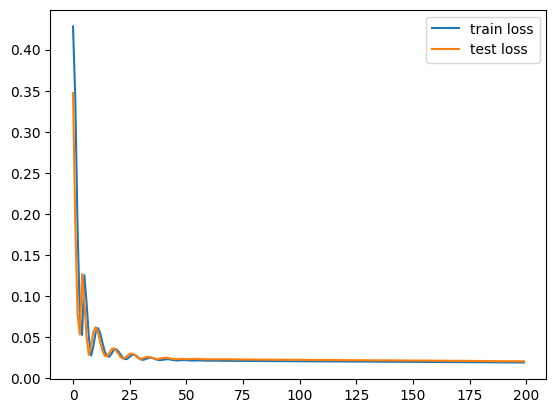

In [12]:
# Plot the train and test losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [13]:
# "Wrong" forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, T, 1)
    p = model(input_)[0, 0].item()  # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

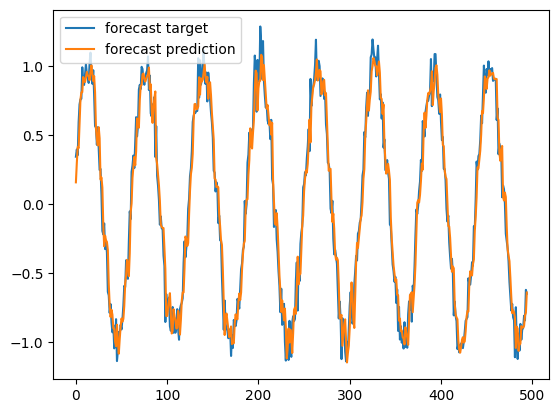

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

In [15]:
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0, 0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

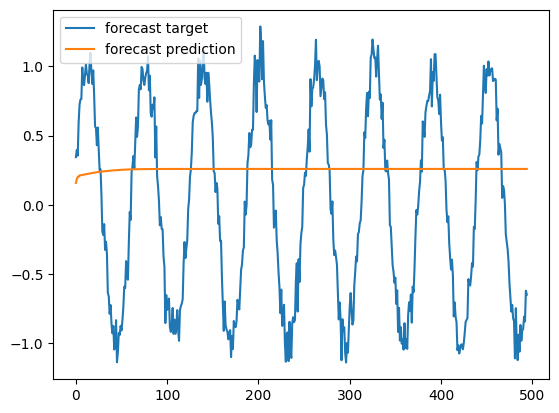

In [16]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()